In [1]:
### V1: Reads and saves spectrum plots from GIRAFFE pipeline products 
### V2: Uses iteration to spit out spectra for one folder of GIRAFFE pipeline products
### V3: Same as V2 but for ALL folders of GIRAFFE pipeline products
### V5: Read multiple exposures of a star, resample them all, then coadd spectra
### V6: Continuing from V5, we normalize the flux by fitting the continuum.
### V7: Instead of coadding before normalizing, we esample, normalize, then coadd spectra. Also can now load Table 1 from Hur et al. 2012
### V8: Find out which stars actually have at least one exposure. This version also includes 5 spectra on one plot,
### and two plots of spectra up close
### V8_random: Same as V8 but looks at 5 randomly chosen stars instead of brightest stars
### V8.3: Same as V8_random, but looks at 3 stars deliberately chosen for resolved peaks instead of 5.
### V8.4: Same as V8.3 with attempted cross-correlations
### V8.5: Now features RV calculation for a single star by fitting positions of MgI and Fe lines
### V8.6: Added function to mask out emission lines


from astropy.io import fits
from astropy import units as u
from astropy.table import Table
import pandas as pd
import numpy as np
import os
import glob
from io import StringIO
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fafe18bac50>

In [2]:
# Load Hur et al. 2012 table

df = pd.read_fwf('table1.dat', infer_nrows=1001)
IDs = df.iloc[:, 0]
V_mags = df.iloc[:, 7]
print(df)

        ID Ah Am  RAs  Ed Em  DEs    Vmag  U-B    B-V    V-I     e_  e_.1  \
0        1 10 42 57.6 -59 47 22.6  18.681  NaN  1.105  1.461  0.002   NaN   
1        2 10 42 57.7 -59 44 22.2  18.303  NaN    NaN  2.764  0.012   NaN   
2        3 10 42 57.7 -59 46 58.0  18.610  NaN    NaN  1.573  0.038   NaN   
3        4 10 42 57.8 -59 47 49.5  12.870  NaN  0.764  0.799  0.009   NaN   
4        5 10 42 57.8 -59 44 03.4  18.815  NaN  1.072  1.433  0.017   NaN   
...                           ...     ...  ...    ...    ...    ...   ...   
4538  4539 10 45 54.5 -59 36 22.1  17.707  NaN    NaN  1.255  0.017   NaN   
4539  4540 10 45 54.5 -59 31 21.9  18.151  NaN  1.049  1.767  0.031   NaN   
4540  4541 10 45 54.6 -59 32 57.5  17.558  NaN  1.102  1.122  0.024   NaN   
4541  4542 10 45 54.7 -59 31 41.7  18.787  NaN    NaN  2.000  0.042   NaN   
4542  4543 10 45 54.7 -59 32 40.8  16.477  NaN  0.985  1.339  0.010   NaN   

       e_.2   e_ _  _  _.1  _.2               mb n_ 2MASS  
0     0.103  0.

In [3]:
# Read all 45 GIRAFFE end product directories

list_dataset_dirs = glob.glob("2022-07-25T11_15_17/2022-07-25T11:15:17/*")
list_dataset_dirs.remove('2022-07-25T11_15_17/2022-07-25T11:15:17/README')
list_dataset_dirs = {x.replace('2022-07-25T11_15_17/2022-07-25T11:15:17/', '') for x in list_dataset_dirs}
print("Total list of Reflex end products: " + str(len(list_dataset_dirs)))

Total list of Reflex end products: 45


In [4]:
# Read all 45 GIRAFFE spectra files

from specutils import Spectrum1D

F_prefix = ["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8"]
list_spectra_dirs = []

for dataset in list_dataset_dirs:
    
    #print("Now working with data from " + dataset)
    
    for F in F_prefix:
        
        spectra_path = "2022-07-25T11_15_17/2022-07-25T11:15:17/"+dataset+"/"+F+"-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits"
        # Check whether the specified path exists or not
        isExist = os.path.exists(spectra_path)
        if not isExist:
            continue
        if isExist: 
            #print(spectra_path)
            list_spectra_dirs.append(spectra_path)  
            break
    
print("Total list of spectra files: "+ str(len(list_spectra_dirs)))

Total list of spectra files: 45


In [5]:
# Read all OBJECT names in RBNSPECTRA files

total_objects = []

for spectra_path in list_spectra_dirs:

    f = fits.open(spectra_path)
    cat = Table.read(spectra_path) # alternative table
    specdata = f[0].data
    np.shape(specdata)
    
    for object_i in range(len(f[1].data['OBJECT'])):
        
        total_objects.append(f[1].data['OBJECT'][object_i])


In [6]:
# Basic statistics

total_spectra = [row for row in total_objects if row != "CALSIM" and not row.startswith("Sky")]
print("Total spectra of stars: " + str(len(total_spectra)))

# Remove duplicates to determine total stars
total_sources = list(set(total_spectra)) 
print("Total sources: " + str(len(total_sources)))

# Order Hur et al. 2012 star names by increasing number
total_sources = list(map(int, total_sources))
total_sources.sort()
total_sources = list(map(str, total_sources))


Total spectra of stars: 4901
Total sources: 873


In [7]:
# Hur et al (2012) Table 1 but for all sources/stars we actually collected with VLT

rows = [int(x) for x in total_sources]
df_filtered = df[df.iloc[:, 0].isin(rows)]
print(df_filtered)

Empty DataFrame
Columns: [ID Ah Am  RAs  Ed Em  DEs, Vmag, U-B, B-V, V-I, e_, e_.1, e_.2, e_ _, _, _.1, _.2, mb n_ 2MASS]
Index: []


In [8]:
# For each star: gather multiple exposures of the star, resample, normalize flux, then coadd spectra

import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

from specutils.manipulation import FluxConservingResampler
import numpy as np

star_IDs = ['2620']#sampled_list 
exposures = [] # number of exposures corresponding to each star

s = {} # dictionary which will hold spectra for each star ID

for star_ID in star_IDs:

    d = {} # dictionary which will hold multiple exposures before coadding

    for spectra_path in list_spectra_dirs:
        f = fits.open(spectra_path)
        cat = Table.read(spectra_path) # alternative table
        specdata = f[0].data
        np.shape(specdata)

        for i in range(len(f[1].data['OBJECT'])):
            if f[1].data['OBJECT'][i] == star_ID:

                # Load spectral data from exposure 
                ''''''
                print(spectra_path)

                lamb = (
                    (np.arange(1, f[0].header['NAXIS2']+1, 1)-f[0].header['CRPIX2'])
                    *
                    f[0].header['CDELT2'] + f[0].header['CRVAL2']
                ) * 10 * u.AA
                column=i

                flux = specdata[:,column] * u.adu
                spec = Spectrum1D(spectral_axis=lamb, flux=flux)

                # Resampling, to put spectra on a common wavelength grid

                new_disp_grid = np.arange(5100, 5400, 0.07) * u.AA

                fluxcon = FluxConservingResampler()
                new_spec_fluxcon = fluxcon(spec, new_disp_grid) 

                # Normalize flux

                with warnings.catch_warnings():  # Ignore warnings
                    warnings.simplefilter('ignore')
                    g1_fit = fit_generic_continuum(new_spec_fluxcon)

                y_continuum_fitted = g1_fit(new_spec_fluxcon.spectral_axis)

                spec_normalized = new_spec_fluxcon / y_continuum_fitted

                d["spec" + str(len(d)+1)] = spec_normalized 

    print("Exposures of " + star_ID + ": " + str(len(d)))
    
    exposures.append(len(d))
    
    # Coadding spectra
    coadded_spec = d['spec1']
    for i in range(2,len(d)+1): 
        coadded_spec = coadded_spec + d['spec'+str(i)]
       
    s["star" + str(len(s)+1)] = coadded_spec 

2022-07-25T11_15_17/2022-07-25T11:15:17/GIRAF.2021-02-15T03:32:45.041/F5-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits
2022-07-25T11_15_17/2022-07-25T11:15:17/GIRAF.2021-02-15T02:47:41.816/F5-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits
2022-07-25T11_15_17/2022-07-25T11:15:17/GIRAF.2021-02-15T01:45:02.019/F5-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits
2022-07-25T11_15_17/2022-07-25T11:15:17/GIRAF.2021-02-15T02:05:55.374/F5-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits
2022-07-25T11_15_17/2022-07-25T11:15:17/GIRAF.2021-02-15T03:11:52.045/F5-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits
2022-07-25T11_15_17/2022-07-25T11:15:17/GIRAF.2021-02-15T02:26:48.390/F5-Carina-FLAMES_SCIENCE_RBNSPECTRA.fits
Exposures of 2620: 6


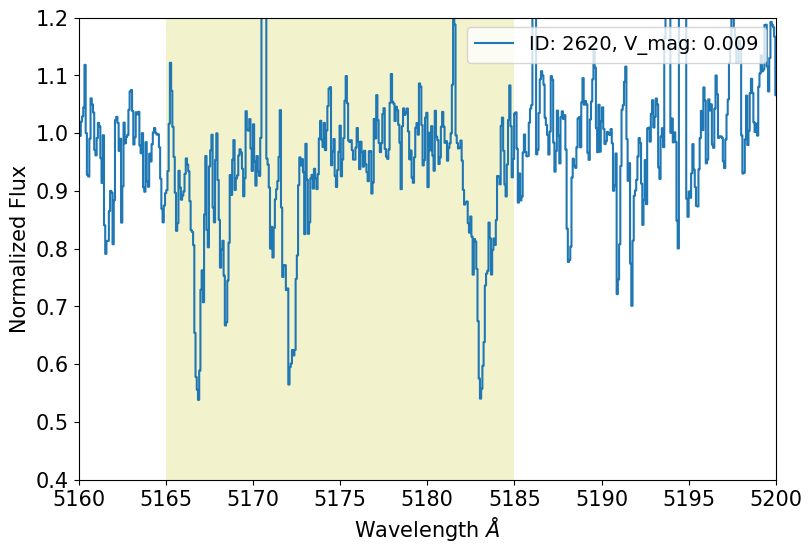

In [9]:
# Plotting both the curves simultaneously
f, ax = plt.subplots()

offset = 0
for i in range(len(star_IDs)):
    ax.step(s["star"+str(i+1)].spectral_axis, offset+s["star"+str(i+1)].flux/exposures[i], 
            label="ID: " + star_IDs[i] + ", V_mag: " + str(V_mags[int(star_IDs[i])-1]))
    offset += 0

ax.set_ylim([0.4, 1.2])
ax.set_xlim([5160, 5200])

ax.set_xlabel("Wavelength $\AA$", fontsize=15)
ax.set_ylabel("Normalized Flux", fontsize=15)

ax.axvspan(5165, 5185, color='y', alpha=0.2, lw=0)

plt.legend(loc="upper right", prop={'size': 14})

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)

f.set_size_inches(9, 6)

spec_axis = s["star"+str(i+1)].spectral_axis
spec_flux = s["star"+str(i+1)].flux/exposures[i]

plt.savefig("2620_spectrum")

RV = -27.121555635365063 ± 1.239094985328636 km s


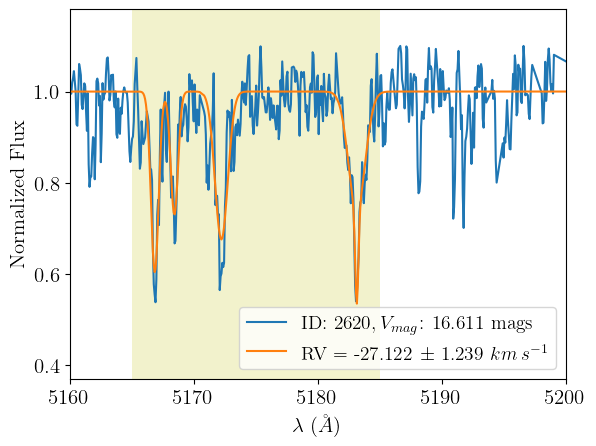

In [22]:
from matplotlib import rc
import numpy as np
from specutils.analysis import template_comparison
from astropy.nddata import NDData, StdDevUncertainty
from PyAstronomy import pyasl

spec_axis = s["star1"].spectral_axis
spec_flux = s["star1"].flux/exposures[int(1)-1]

observed_spectrum = Spectrum1D(spectral_axis=spec_axis*(1+observed_redshift),
                flux=spec_flux, uncertainty=StdDevUncertainty(spec_flux))

spectral_template = Spectrum1D(spectral_axis=spec_axis, flux=spec_flux, 
                            uncertainty=StdDevUncertainty(spec_flux))

# Make a Gaussian
def gaussian(x, A, mu, sigma):
    return -A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Add 5 Gaussians together to represent 4 lines
def model(x, rv, a1, s1, a2, s2, a3, s3, a4, s4, a5, s5):
    r_shift = 1 +rv/3e5
    mu1, mu2, mu3, mu4 = r_shift * np.array([5167.33, 5168.91, 5172.70, 5183.62])
    modflux = (1 + gaussian(x, a1, mu1, s1) + gaussian(x, a2, mu2, s2)
                 + gaussian(x, a3, mu3, s3) + gaussian(x, a4, mu4, s4)
                 + gaussian(x, a5, mu4, s5))
    return modflux

# Use non-linear least squares to fit model to observed spectrum
from scipy.optimize import curve_fit
p0=[0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # Initial guess of fluxes
popt, pcov = curve_fit(model, spectral_template.spectral_axis.value[mask], spectral_template.flux.value[mask], p0=p0)
print(f"RV = {popt[0]} \u00B1 {np.sqrt(pcov[0,0])} km s")

# Mask values above the continuum
mask = spectral_template.flux < 1.1
        
# Plot
fig, ax = plt.subplots()
ax.plot(spectral_template.spectral_axis[mask], spectral_template.flux[mask], 
        label="ID: 2620" + r"$, V_{mag}$" + ": 16.611 mags")
ax.plot(spectral_template.spectral_axis.value[mask], model(spectral_template.spectral_axis.value[mask], *popt),
        label=f"RV = {round(popt[0],3)}" + r" $\pm$ " + f"{round(np.sqrt(pcov[0,0]),3)} "+ r"$km\,s^{-1}$")
ax.set_xlim(5160, 5200)
ax.set_ylim(0.37, 1.18)
f.set_size_inches(13, 9)
ax.axvspan(5165, 5185, color='y', alpha=0.2, lw=0)
plt.legend(loc="lower right", prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel("$\lambda$ ($\AA$)", fontsize=15)
ax.set_ylabel("Normalized Flux", fontsize=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman"
})


plt.savefig("2620_gaussian_fits_with_mask.png")
